In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from tqdm.auto import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [4]:
import os
from typing import Tuple
import torchaudio
from torch.utils.data import Dataset
from torch import Tensor
from pathlib import Path

def load_audio_item(filepath: str, path: str, label_name: str) -> Tuple[Tensor, int, str, str]:
    relpath = os.path.relpath(filepath, path)
    label, filename = os.path.split(relpath)
    if label_name is not None:
        label = label_name
    waveform, sample_rate = torchaudio.load(filepath, normalize = True, channels_first = True)
    return waveform, sample_rate, label, filename

class AudioFolder(Dataset):
    """Create a Dataset from Local Files.
    Args:
        path (str): Path to the directory where the dataset is found or downloaded.
        suffix (str) : Audio file type, defaulted to ".WAV".
        pattern (str) : Find pathnames matching this pattern. Defaulted to "*/*" 
        new_sample_rate (int) : Resample audio to new sample rate specified.
        spectrogram_transform (bool): If `True` transform the audio waveform and returns it  
        transformed into a spectrogram tensor.
        label (str): The label is pulled from the folders in the path, this allows you to statically
        define the label string.
    """


    def __init__(
            self,
            path: str,
            suffix: str = ".wav",
            pattern: str = "*/*",
            new_sample_rate: int = None,
            spectrogram_transform: bool = False,
            label: str = None
                    ):

        self._path = path
        self._spectrogram_transform = spectrogram_transform
        self._new_sample_rate = new_sample_rate
        self._label = label

        walker = sorted(str(p) for p in Path(self._path).glob(f'{pattern}{suffix}'))
        self._walker = list(walker)

    def __getitem__(self, n: int) -> Tuple[Tensor, int, str, str]:
        """Load the n-th sample from the dataset.
        Args:
            n (int): The index of the file to be loaded
        Returns:
            tuple: ``(waveform, sample_rate, label, filename)``
        """
        fileid = self._walker[n]

        waveform, sample_rate, label, filename =  load_audio_item(fileid, self._path, self._label)

        if self._new_sample_rate is not None:
            waveform = torchaudio.transforms.Resample(sample_rate, self._new_sample_rate)(waveform)
            sample_rate = self._new_sample_rate
        if self._spectrogram_transform is True:
           waveform = torchaudio.transforms.Spectrogram()(waveform)

        return waveform, sample_rate, label, filename



    def __len__(self) -> int:
        return len(self._walker)

In [5]:
db = AudioFolder(path='./records_by_classes/')

In [6]:
train_set, test_set = torch.utils.data.random_split(db, [0.7, 0.3])

In [7]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

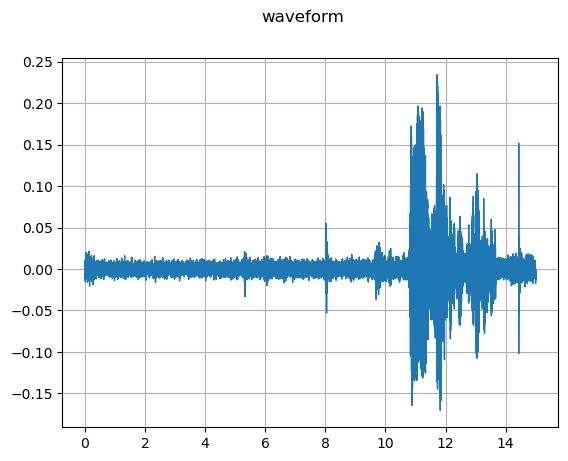

In [8]:
waveform, sample_rate, label, file_name = train_set[0]
plot_waveform(waveform, sample_rate)

In [9]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['bad', 'good', 'neutral']

In [10]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [11]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

In [12]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors.to(device), targets.to(device)

batch_size = 4
train_loader = torch.utils.data.DataLoader(
    train_set, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=collate_fn,
    batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(
    test_set, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=collate_fn,
    batch_size=batch_size)


## Network

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in [this paper](https://arxiv.org/pdf/1610.00087.pdf)_. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [13]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Training and Testing

In [14]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target, *_) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        # loss = F.nll_loss(output.squeeze(), target)
        loss = F.cross_entropy(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch}\t[{(batch_idx * len(data)):5.0f}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):3.0f}%)]\tLoss: {loss.item():.4f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [15]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    accuracy = 100. * correct / len(test_loader.dataset)
    print(f" Test Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n")
    return accuracy

In [16]:
log_interval = 20
n_epoch = 20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
accuracies = []

model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # reduce the learning after 4 epochs by a factor of 10
# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch, 
          bar_format = "{desc}: {percentage:.2f}%|{bar}| {n:.2f}/{total_fmt} [{elapsed}<{remaining}]",
          colour = 'GREEN',
          ) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        accuracy_step = test(model, epoch)
        accuracies.append(accuracy_step)
        scheduler.step()


0.00%|          | 0.00/20 [00:00<?]

Train Epoch: 1	[    0/103 (  0%)]	Loss: 1.1809
Train Epoch: 1	[   80/103 ( 77%)]	Loss: 1.3300
 Test Epoch: 1	Accuracy: 10/44 (23%)

Train Epoch: 2	[    0/103 (  0%)]	Loss: 0.7806
Train Epoch: 2	[   80/103 ( 77%)]	Loss: 0.9981
 Test Epoch: 2	Accuracy: 26/44 (59%)

Train Epoch: 3	[    0/103 (  0%)]	Loss: 0.4717
Train Epoch: 3	[   80/103 ( 77%)]	Loss: 1.6112
 Test Epoch: 3	Accuracy: 33/44 (75%)

Train Epoch: 4	[    0/103 (  0%)]	Loss: 0.6223
Train Epoch: 4	[   80/103 ( 77%)]	Loss: 0.5013
 Test Epoch: 4	Accuracy: 33/44 (75%)

Train Epoch: 5	[    0/103 (  0%)]	Loss: 1.7932
Train Epoch: 5	[   80/103 ( 77%)]	Loss: 1.3279
 Test Epoch: 5	Accuracy: 31/44 (70%)

Train Epoch: 6	[    0/103 (  0%)]	Loss: 0.9266
Train Epoch: 6	[   80/103 ( 77%)]	Loss: 0.4287
 Test Epoch: 6	Accuracy: 32/44 (73%)

Train Epoch: 7	[    0/103 (  0%)]	Loss: 0.4659
Train Epoch: 7	[   80/103 ( 77%)]	Loss: 0.8398
 Test Epoch: 7	Accuracy: 32/44 (73%)

Train Epoch: 8	[    0/103 (  0%)]	Loss: 0.6686
Train Epoch: 8	[   80/103 ( 7

Text(0.5, 1.0, 'training loss')

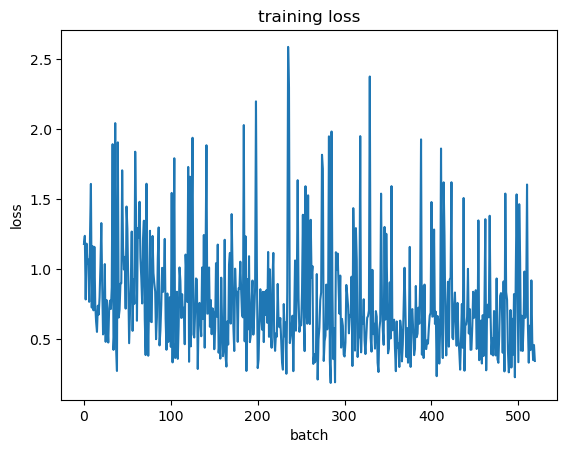

In [17]:
plt.plot(losses)
plt.xlabel('batch')
plt.ylabel('loss')
plt.title("training loss")

Text(0.5, 1.0, 'validation accuracy')

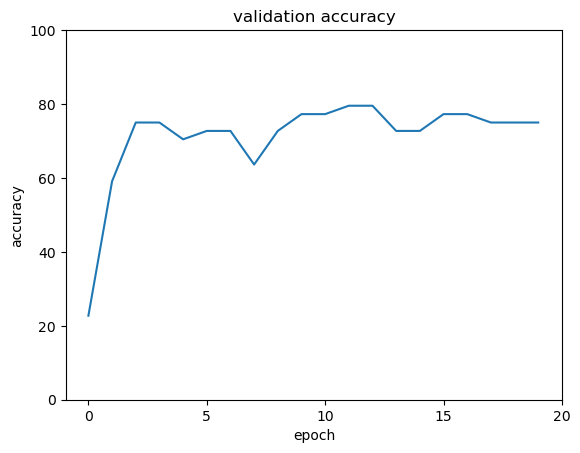

In [39]:
ax = plt.plot(accuracies)

plt.ylim(0, 100)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xticks(range(0, len(accuracies)+1, 5))
plt.title("validation accuracy")

In [19]:
print(count_parameters(model))

24835


[1 2 1 1 1 2 1 1 1 1 1 0 0 0 1 1 1 2 1 2 1 0 2 1 0 1 2 1 1 1 1 1 1 2 2 0 1
 2 1 0 2 1 1 0]
[1 2 1 2 1 2 1 2 2 1 1 0 2 0 0 1 1 2 2 0 0 0 1 1 2 0 0 1 1 1 2 1 1 1 0 0 1
 2 2 0 0 1 1 0]


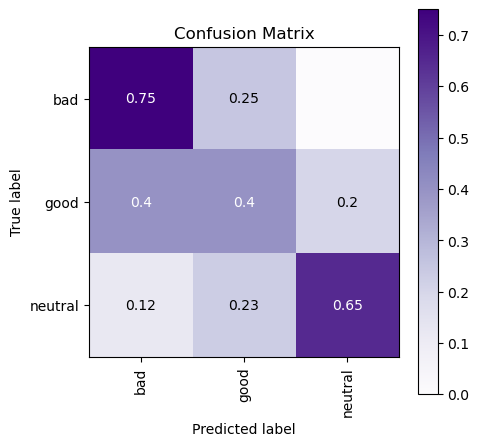

In [38]:
target_classes = {0:"bad", 1:"neutral", 2:"good"}
import numpy as np

def print_results(Y_actual, Y_preds, target_names):
    from sklearn.metrics import confusion_matrix
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    

    skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Purples",
                                        hide_zeros=True,
                                        figsize=(5,5)
                                        )
    plt.xticks(rotation=90)

def make_predictions(model):
    Y_shuffled, Y_preds = [], []

    model.eval()
    correct = 0

    with torch.no_grad():
       for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
  
        predicted_label = model(data)
        
        Y_preds.append(predicted_label)
        Y_shuffled.append(target)
            
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)
    
    a = F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().cpu().numpy()
    b = []
    for i in list(a):
       b.append(i[0])
    a = np.array(b)

    return Y_shuffled.detach().cpu().numpy(), a


Y_actual, Y_preds = make_predictions(model)
print(Y_actual)
print(Y_preds)
print_results(Y_actual, Y_preds, target_classes)